In [2]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp

In [3]:
# 12hrs light, 12hrs dark
def LD(t, intensity, off_time=12, daylength=24):
    time = t % daylength
    is_light = time < off_time
    
    return is_light * intensity

# LD function with a pulse of light or dark at the specified time and day, for the specified length (in hours)
def LD_pulse(t, intensity, pulse_day, pulse_time, pulse_length=2, off_time=12, daylength=24):
    time = t % daylength
    day = t // daylength
    base = LD(t, intensity, off_time, daylength)

    is_during_pulse = (day == pulse_day) & (pulse_time < time) & (time < pulse_time + pulse_length)

    # if not in pulse, return the base signal; if in pulse return the inverted one
    # done a little weirdly so that the function works when vectorized
    return is_during_pulse * (intensity - base) + (1 - is_during_pulse) * base

In [70]:
# differential equations for x, y
def xy_lights(t, p, l, A, tau, light_func):
    x, y = p
    r = np.sqrt(x**2 + y**2)
    
    dx = l * x * (A - r) - 2 * np.pi * y / tau - light_func(t)
    dy = l * y * (A - r) + 2 * np.pi * x / tau
    return [dx, dy]

def xyz_lights(t, p, l, A, tau, light_func):
    x, y, z = p

    dx = -l*x + 1 / (1 + z**10)
    dy = -l*y + x - light_func(t)
    dz = -l*z + y
    return [dx, dy, dz]

def xy_lights_locomotion(t, p, l, A, tau, light_func, activation_func):
    x, y, L = p
    r = np.sqrt(x**2 + y**2)
    light_intensity = light_func(t)
    
    dx = l * x * (A - r) - 2 * np.pi * y / tau - light_intensity
    dy = l * y * (A - r) + 2 * np.pi * x / tau
    dL = -L + activation_func(x) - light_intensity

    return [dx, dy, dL]
    
# solve the differential equations to get values of time, x, and y across the specified time period
# uses the base LD cycle (NO PULSE)
# returns a nested tuple (t, (x, y))
def get_simulation_result(l, tau, hours, intensity, timestep=1/60, A=1):
    tspan = [0, hours]
    t = np.arange(*tspan, timestep)
    
    light_func = lambda t: LD(t, intensity)
    p0 = [A, 0]
    
    result = solve_ivp(xy_lights, tspan, p0, args=(l, A, tau, light_func), t_eval=t)
    return t, result.y

def get_3_simulation_result(l, tau, hours, intensity, timestep=1/60, A=1):
    tspan = [0, hours]
    t = np.arange(*tspan, timestep)
    
    light_func = lambda t: LD(t, intensity)
    p0 = [A, .5*A, 0]
    
    result = solve_ivp(xyz_lights, tspan, p0, args=(l, A, tau, light_func), t_eval=t)
    return t, result.y

# same as above, but uses the light pulse
def get_pulse_simulation_result(l, tau, hours, intensity, pulse_day, pulse_time, pulse_length=2, timestep=1/60, A=1):
    tspan = [0, hours]
    t = np.arange(*tspan, timestep)
    
    light_func = lambda t: LD_pulse(t, intensity, pulse_day, pulse_time, pulse_length)
    p0 = [A, 0]
    
    result = solve_ivp(xy_lights, tspan, p0, args=(l, A, tau, light_func), t_eval=t)
    return t, result.y

def get_3_pulse_simulation_result(l, tau, hours, intensity, pulse_day, pulse_time, pulse_length=2, timestep=1/60, A=1):
    tspan = [0, hours]
    t = np.arange(*tspan, timestep)
    
    light_func = lambda t: LD_pulse(t, intensity, pulse_day, pulse_time, pulse_length)
    p0 = [.1, A, A]
    
    result = solve_ivp(xyz_lights, tspan, p0, args=(l, A, tau, light_func), t_eval=t)
    return t, result.y

def get_pulse_locomotion_simulation_result(l, tau, hours, intensity, activation_func, pulse_day, pulse_time, pulse_length=2, timestep=1/60, A=1):
    tspan = [0, hours]
    t = np.arange(*tspan, timestep)
    
    light_func = lambda t: LD_pulse(t, intensity, pulse_day, pulse_time, pulse_length)
    p0 = [A, 0, 0]
    
    result = solve_ivp(xy_lights_locomotion, tspan, p0, args=(l, A, tau, light_func, activation_func), t_eval=t)
    return t, result.y

In [5]:
def get_locomotion(x_level, activation_func, light_func):
    L = activation_func(x_level)

    return L

In [6]:
def simple_sigmoid(x, center=0, slope=1):
    return 1 / (1 + np.exp(-4*slope*(x - center)))

(96.0, 168.0)

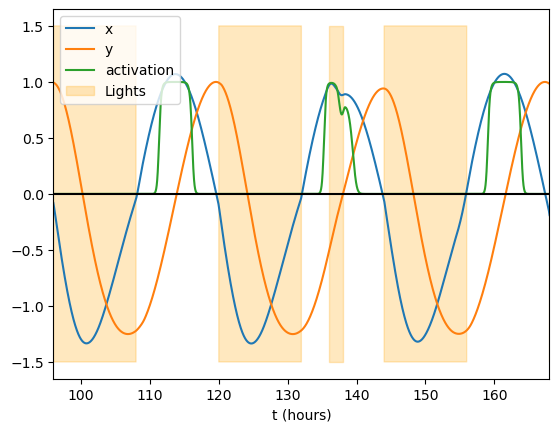

In [78]:
l = .2
tau = 23
hours = 10*24
intensity = .15
pulsetime = 16

t, (x, y) = get_pulse_simulation_result(l, tau, hours, intensity, 5, pulsetime)
lights = lambda t: LD_pulse(t, intensity, 5, pulsetime)

L = simple_sigmoid(x/np.max(x), .8, 10)

plt.plot(t, x)
plt.plot(t, y/np.max(y))
plt.plot(t, L)
plt.fill_between(t, -1.5, 1.5, where=(lights(t) > 0), color='orange', alpha=.25)
plt.plot([0, hours], [0, 0], color='black')
plt.legend(['x', 'y', 'activation', 'Lights'])
plt.xlabel('t (hours)')
plt.xlim(24*4, 24*7)

(336.0, 408.0)

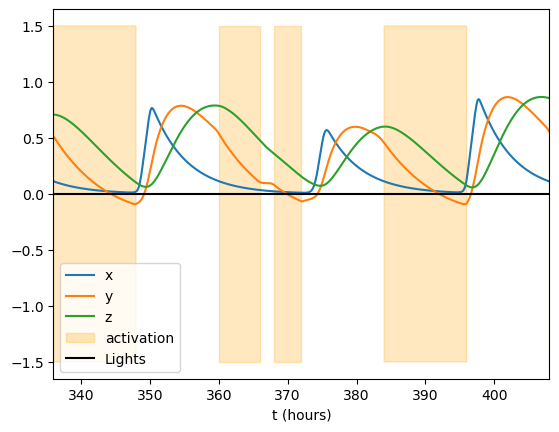

In [101]:
l = .2
tau = 24
hours = 20*24
intensity = .15
pulsetime = 6

t, (x, y, z) = get_3_pulse_simulation_result(l, tau, hours, intensity, 15, pulsetime)
lights = lambda t: LD_pulse(t, intensity, 15, pulsetime)

L = simple_sigmoid(x/np.max(x), .5, 5)

plt.plot(t, x/np.max(x))
plt.plot(t, y/np.max(y))
plt.plot(t, z/np.max(z))
#plt.plot(t, L)
plt.fill_between(t, -1.5, 1.5, where=(lights(t) > 0), color='orange', alpha=.25)
plt.plot([0, hours], [0, 0], color='black')
plt.legend(['x', 'y', 'z', 'activation', 'Lights'])
plt.xlabel('t (hours)')
plt.xlim(24*14, 24*17)
#plt.xlim(0, 96)